# 프로젝트: 뉴스기사 요약해보기

## Step 0. 라이브러리 준비 및 과제 확인하기

- 사용 데이터: [뉴스 기사 데이터](https://github.com/sunnysai12345/News_Summary)
- **추상적 요약** 방식으로 데이터 전처리, 어텐션 메커니즘 설계, 결과 비교 수행하기
- Summa를 사용한 추출적 요약 해보기

평가 기준
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
 - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
- train loss와 validation loss 감소 경향 시각화
 - 실제 요약문의 핵심 단어가 예측 요약 문장에 포함되었는지 확인
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해 보았다.
- 두 요약 결과를 문법완성도 측면, 핵심단어 포함 측면으로 나누어 비교분석
- 분석 결과 표로 제시

In [4]:
from nltk.corpus import stopwords
import nltk
import tensorflow as tf
import summa
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


## Step 1. 데이터 수집하기

In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding = 'iso-8859-1')

In [6]:
data.sample(10) # headlines, text로 구성된 데이터 확인

,headlines,text
669,I don't need any godfather in the industry: An...,Actress Ankita Lokhande has said she doesn't n...
68314,"Taps, carpets stolen during Mahamana Express' ...","Three taps, four hand showers, and two carpets..."
60951,No Rajput queen danced in front of anyone: Jas...,While referring to the song 'Ghoomar' from 'Pa...
59193,Messi denied goal despite ball crossing line i...,Lionel Messi was denied a legitimate goal desp...
73704,Hope Centre stops snooping: Cong after SC verd...,After the Supreme Court's verdict on right to ...
44033,Firms' directors booked for 'get rich quick' f...,The Directors of seven firms have been booked ...
79380,DDA to submit action plan for restoring Yamuna...,The National Green Tribunal (NGT) on Friday di...
13504,"Robot dog climbs stairs, jumps hurdles at cons...","A video shows robot dog Spot, developed by Sof..."
53221,Coimbatore's RS Puram Police Station ranked be...,The B2 RS Puram Police Station in Tamil Nadu's...
53446,"Parineeti, Disha, Kiara to star in fourth 'Hou...","As per reports, actresses Parineeti Chopra, Di..."


## Step 2. 데이터 전처리하기(추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요없다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [7]:
# 중복 샘플 확인
print('Unique Text: ', data['text'].nunique())
print('Unique Summary: ', data['headlines'].nunique())
# 98401개의 전체 데이터 중 Text는 41개, Summary는 121개가 중복됨

Unique Text:  98360
Unique Summary:  98280


In [8]:
# 요약은 겹칠 수 있다고 판단, 중복인 Text만 제거함
data.drop_duplicates(subset=['text'], inplace=True)
print(len(data))

98360


In [9]:
# 결측치 확인
print(data.isna().sum()) # 결측치 없음

headlines    0
text         0
dtype: int64


[정규화 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [10]:
# 텍스트 정규화
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [11]:
nltk.download('stopwords') # nltk 불용어 다운로드

[nltk_data] Downloading package stopwords to /Users/jmson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('english'))
print(len(stop_words))

179


In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 감싸진 문자열 제거
    sentence = re.sub('"','', sentence) # "" 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 정규화
    sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경(ex. emmmm)
    
    # 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
# text 전처리(불용어 제거함)
clean_text = []
for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
# headlines 전처리(불용어 제거하지 않음)
clean_summary = []
for sentence in data['headlines']:
    clean_summary.append(preprocess_sentence(sentence, False))
    
clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
# 전처리 후 저장
data['text'] = clean_text
data['headlines'] = clean_summary

In [17]:
# 공백인 샘플 null처리
data.replace('', np.nan, inplace=True)
print(data.isna().sum()) # null 확인

headlines    0
text         0
dtype: int64


min text: 1
max text: 60
text mean: 35.103599023993496
min headline: 1
max headline: 19
headline mean: 9.307015046766978


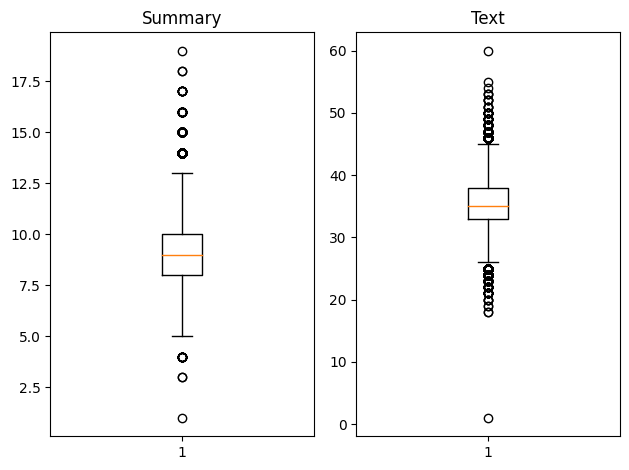

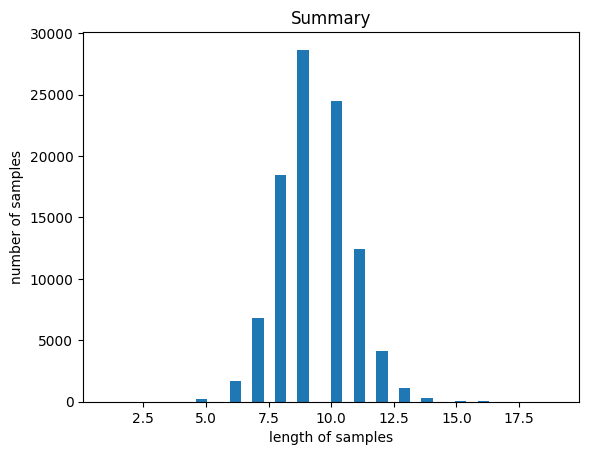

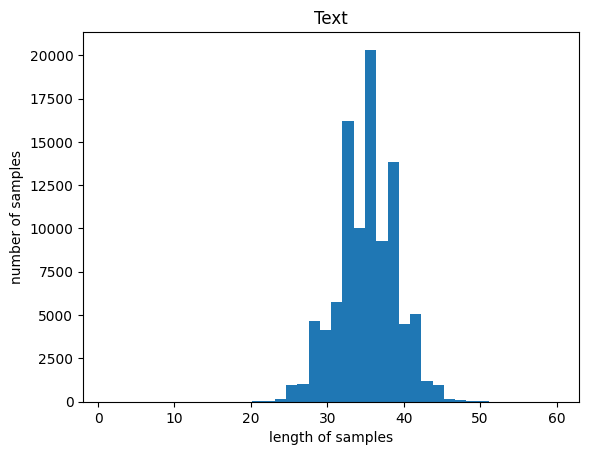

In [18]:
# 길이 분포 확인
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print(f'min text: {np.min(text_len)}')
print(f'max text: {np.max(text_len)}')
print(f'text mean: {np.mean(text_len)}')
print(f'min headline: {np.min(summary_len)}')
print(f'max headline: {np.max(summary_len)}')
print(f'headline mean: {np.mean(summary_len)}')

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# text와 headline(summary) 최대길이 설정
# 평균보다 조금 크게 설정함
text_max_len = 40
summary_max_len = 11

In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1

    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플 비율: {cnt/len(nested_list)}')

In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플 비율: 0.9236884912566083
전체 샘플 중 길이가 11 이하인 샘플 비율: 0.9426291175274502


In [22]:
# 최대 길이보다 큰 샘플 제거
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print(f'samples: {len(data)}')

samples: 85607


In [23]:
# 요약 데이터에 시작, 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [24]:
# 인코더의 입력, 디코더의 입력/레이블 지정
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [25]:
# train, test data 분리
indices = np.arange(encoder_input.shape[0]) # 정수 시퀀스 생성
np.random.shuffle(indices)
print(indices)

[ 4260 67666  1859 ... 16432 82575 29296]


In [26]:
# shuffle sample
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print(f'test data: {n_of_val}')

test data: 17121


In [28]:
# train, test data 준비
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [29]:
print(f'encoder input train: {len(encoder_input_train)}')
print(f'decoder input train: {len(decoder_input_train)}')
print(f'encoder input test: {len(encoder_input_test)}')
print(f'decoder input test: {len(decoder_input_test)}')

encoder input train: 68486
decoder input train: 68486
encoder input test: 17121
decoder input test: 17121


In [30]:
# tokenizer 정의
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [31]:
# 단어 등장 빈도수 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도수 < threshold
total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수 < threshold 총 합

for key, value in src_tokenizer.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print(f'단어 집합의 크기: {total_cnt}')
print(f'등장 빈도가 {threshold-1}번 이하인 단어의 수: {rare_cnt}')
print(f'단어 집합에서 희귀 단어를 제외시킬 경우 크기: {total_cnt - rare_cnt}')
print(f'단어 집합에서 희귀 단어의 비율: {(rare_cnt/total_cnt)*100}')
print(f'전체 등장 빈도에서 희귀 단어 등장 비율: {(rare_freq/total_freq)*100}')

단어 집합의 크기: 64747
등장 빈도가 6번 이하인 단어의 수: 44172
단어 집합에서 희귀 단어를 제외시킬 경우 크기: 20575
단어 집합에서 희귀 단어의 비율: 68.22246590575625
전체 등장 빈도에서 희귀 단어 등장 비율: 3.7954392503136654


In [32]:
# 등장 빈도 6회 미만 단어 제외
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

#텍스트 시퀀스를 정수로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
# 단어 등장 빈도수 확인
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도수 < threshold
total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수 < threshold 총 합

for key, value in tar_tokenizer.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print(f'단어 집합의 크기: {total_cnt}')
print(f'등장 빈도가 {threshold-1}번 이하인 단어의 수: {rare_cnt}')
print(f'단어 집합에서 희귀 단어를 제외시킬 경우 크기: {total_cnt - rare_cnt}')
print(f'단어 집합에서 희귀 단어의 비율: {(rare_cnt/total_cnt)*100}')
print(f'전체 등장 빈도에서 희귀 단어 등장 비율: {(rare_freq/total_freq)*100}')

단어 집합의 크기: 28466
등장 빈도가 6번 이하인 단어의 수: 19605
단어 집합에서 희귀 단어를 제외시킬 경우 크기: 8861
단어 집합에서 희귀 단어의 비율: 68.87163633808754
전체 등장 빈도에서 희귀 단어 등장 비율: 5.920937769190923


In [35]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [36]:
# 텍스트 시퀀스 정수로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [37]:
# 빈 셈플 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print(f'drop train: {len(drop_train)}')
print(f'drop test: {len(drop_test)}')

drop train: 1
drop test: 0


In [38]:
# drop할 test data가 없으므로 train data에 대해서만 처리

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

print(f'encoder input train: {len(encoder_input_train)}')
print(f'decoder input train: {len(decoder_input_train)}')
print(f'encoder input test: {len(encoder_input_test)}')
print(f'decoder input test: {len(decoder_input_test)}')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (68486,) + inhomogeneous part.

In [ ]:
# padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

In [ ]:
# 인코더 설계
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

TypeError: Parameter to MergeFrom() must be instance of same class: expected tensorflow.TensorShapeProto got tensorflow.TensorShapeProto.